 # Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding


In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

In [8]:
df_new[df_new['store']==3]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1117,3,4,2015-07-30,8977,823,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2232,3,3,2015-07-29,7610,716,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3347,3,2,2015-07-28,8864,818,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4462,3,1,2015-07-27,8107,768,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011637,3,6,2013-01-05,4523,525,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1012752,3,5,2013-01-04,6069,690,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1013867,3,4,2013-01-03,5902,721,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1014982,3,3,2013-01-02,6823,805,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [9]:
#Store_3
df_new_store3=df_new[df_new['store']==3]

In [10]:
# transform datatype of the variable data to datetime
df_new_store3['date'] = pd.to_datetime( df_new_store3['date'])

In [11]:
df_new_store3.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 2 to 1016097
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [12]:
# Check NAN values
missing_count = df_new_store3.isnull().sum() # the count of missing values
value_count = df_new_store3.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


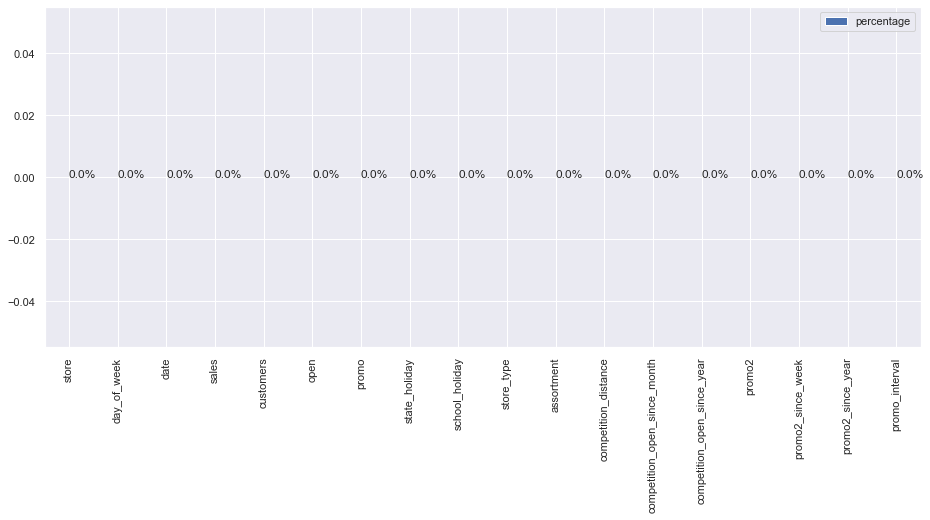

In [13]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [14]:
df_new_store3

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1117,3,4,2015-07-30,8977,823,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2232,3,3,2015-07-29,7610,716,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3347,3,2,2015-07-28,8864,818,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4462,3,1,2015-07-27,8107,768,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011637,3,6,2013-01-05,4523,525,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1012752,3,5,2013-01-04,6069,690,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1013867,3,4,2013-01-03,5902,721,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1014982,3,3,2013-01-02,6823,805,1,0,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [15]:
df_new_store3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 2 to 1016097
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [16]:
df_new_store3 = df_new_store3.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64',})
df_new_store3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 2 to 1016097
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [17]:
# Let's copy the dataset
df_store3 = df_new_store3.copy()

In [18]:
df_store3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1117,3,4,2015-07-30,8977,823,1,1,0,1,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2232,3,3,2015-07-29,7610,716,1,1,0,1,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3347,3,2,2015-07-28,8864,818,1,1,0,1,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4462,3,1,2015-07-27,8107,768,1,1,0,1,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


**Descriptive Statistics**

In [19]:
df_store3.describe().T

,count,mean,std,min,25%,50%,75%,max
store,942.0,3.000000,0.000000,3.0,3.0,3.0,3.00,3.0
day_of_week,942.0,3.997877,1.998404,1.0,2.0,4.0,6.00,7.0
sales,942.0,5741.253715,3298.782559,0.0,4247.5,5892.0,8152.75,15689.0
customers,942.0,620.286624,323.366048,0.0,475.0,705.0,834.75,1579.0
open,942.0,0.826964,0.378479,0.0,1.0,1.0,1.00,1.0
promo,942.0,0.382166,0.486175,0.0,0.0,0.0,1.00,1.0
school_holiday,942.0,0.180467,0.384780,0.0,0.0,0.0,0.00,1.0
competition_distance,942.0,14130.000000,0.000000,14130.0,14130.0,14130.0,14130.00,14130.0
competition_open_since_month,942.0,12.000000,0.000000,12.0,12.0,12.0,12.00,12.0
competition_open_since_year,942.0,2006.000000,0.000000,2006.0,2006.0,2006.0,2006.00,2006.0


In [20]:
# separate numerical and categorical attributes
num_attributes = df_store3.select_dtypes( include = 'number')
cate_attributes = df_store3.select_dtypes( include = 'object')

**Numerical Attributes**


In [21]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,3.0,3.0,0.0,3.000000,3.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,3.997877,4.0,1.997343,0.002127,-1.247185
2,sales,0.0,15689.0,15689.0,5741.253715,5892.0,3297.031148,-0.329182,-0.388584
3,customers,0.0,1579.0,1579.0,620.286624,705.0,323.194365,-0.877069,-0.140779
4,open,0.0,1.0,1.0,0.826964,1.0,0.378278,-1.731453,1.000047
5,promo,0.0,1.0,1.0,0.382166,0.0,0.485917,0.485772,-1.767783
6,school_holiday,0.0,1.0,1.0,0.180467,0.0,0.384576,1.664393,0.771837
7,competition_distance,14130.0,14130.0,0.0,14130.000000,14130.0,0.000000,0.000000,0.000000
8,competition_open_since_month,12.0,12.0,0.0,12.000000,12.0,0.000000,0.000000,0.000000
9,competition_open_since_year,2006.0,2006.0,0.0,2006.000000,2006.0,0.000000,0.000000,0.000000


**Categorical Attributes**

In [22]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday     5
store_type        1
assortment        1
promo_interval    1
dtype: int64

In [23]:
#Let's check the unique values
print(df_store3['state_holiday'].unique())
print(df_store3['store_type'].unique())
print(df_store3['assortment'].unique())
print(df_store3['promo_interval'].unique())

['0' 'a' 'b' 'c' 0]
['a']
['a']
['Jan,Apr,Jul,Oct']


# Exploratory data analysis(EDA)

Let’s perform EDA to gain insights into the given data.

**Univariate Analysis**

Response Variable (target)

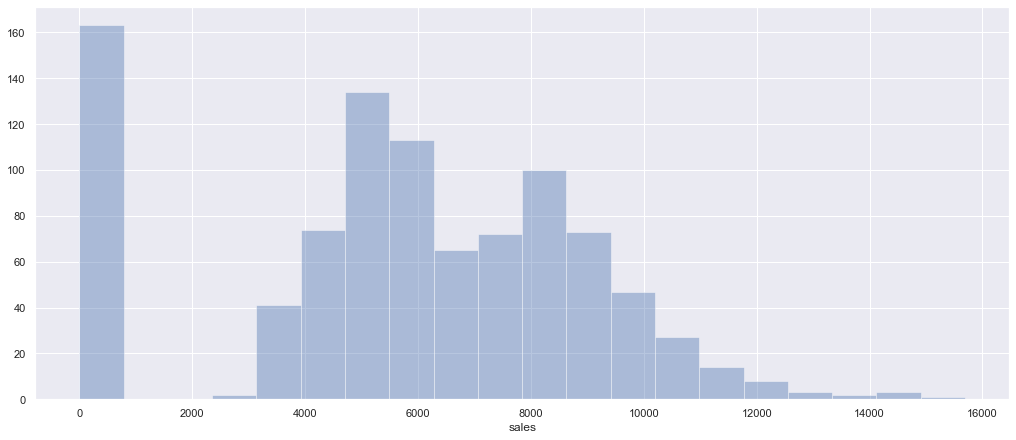

In [24]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store3['sales'], kde = False);
plt.show()

**Numerical Variable**

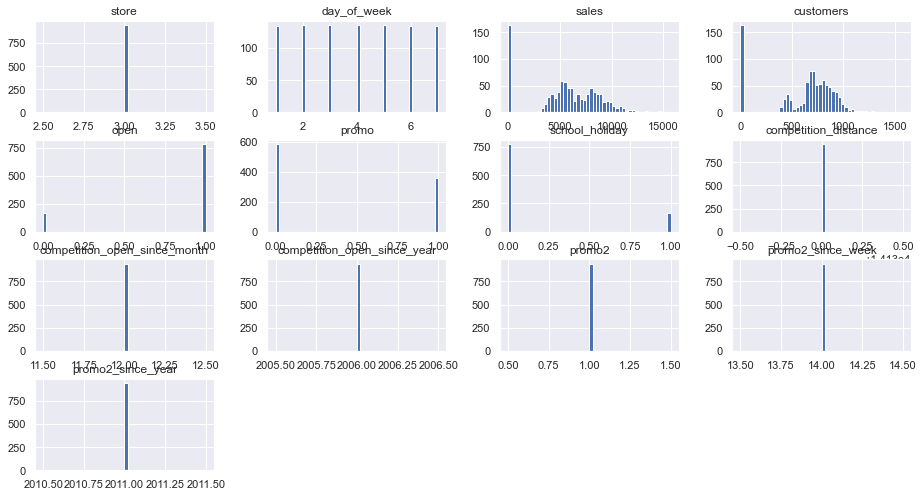

In [25]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [26]:
df_store3['day_of_week'].value_counts()
#day of the week

5    135
4    135
3    135
2    135
7    134
6    134
1    134
Name: day_of_week, dtype: int64

In [27]:
df_store3['open'].value_counts()
# value count of store is open or not

1    779
0    163
Name: open, dtype: int64

In [28]:
df_store3['promo'].value_counts()
# value count of promo

0    582
1    360
Name: promo, dtype: int64

In [29]:
df_store3['state_holiday'].value_counts()
# value count of state_holiday

0    784
0    129
a     19
b      6
c      4
Name: state_holiday, dtype: int64

In [30]:
df_store3['school_holiday'].value_counts()
# value count of state_holiday

0    772
1    170
Name: school_holiday, dtype: int64

In [31]:
df_store3['store_type'].value_counts()
# value count of state_holiday

a    942
Name: store_type, dtype: int64

In [32]:
df_store3['competition_distance'].value_counts()
# value count of competition_distance

14130.0    942
Name: competition_distance, dtype: int64

In [33]:
df_store3['competition_open_since_month'].value_counts()
# value count of competition_open_since_month

12    942
Name: competition_open_since_month, dtype: int64

In [34]:
df_store3['competition_open_since_year'].value_counts()
# value count of competition_open_since_year

2006    942
Name: competition_open_since_year, dtype: int64

In [35]:
df_store3['promo2'].value_counts()
# value count of competition_open_since_year

1    942
Name: promo2, dtype: int64

In [36]:
df_store3['promo2_since_week'].value_counts()
 #value count of promo2_since_week

14.0    942
Name: promo2_since_week, dtype: int64

In [37]:
df_store3['promo2_since_year'].value_counts()
 #value count of promo2_since_year

2011.0    942
Name: promo2_since_year, dtype: int64

**Categorical Variable**

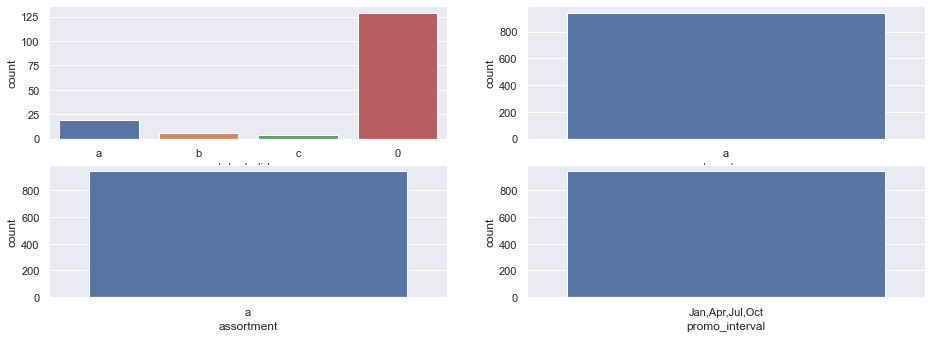

In [38]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store3[df_store3['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store3, x = df_store3['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store3, x = df_store3['assortment'])

# promo_interval
plt.subplot(3, 2, 4)
sns.countplot(data = df_store3, x = df_store3['promo_interval'])
plt.show()

In [39]:
df_store3[df_store3['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
5577,3,7,2015-07-26,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
13382,3,7,2015-07-19,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
21187,3,7,2015-07-12,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
28992,3,7,2015-07-05,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
36797,3,7,2015-06-28,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987107,3,7,2013-01-27,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
994912,3,7,2013-01-20,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1002717,3,7,2013-01-13,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1010522,3,7,2013-01-06,0,0,0,0,0,0,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [40]:
df_store3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 2 to 1016097
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        


-    Sale  and customer colomns has zero values which has to be imputed

-    Store is open on 80% of days

-    80% are regular days

-    All the rows of column-store type belongs to 'a'

-    All the rows of column-assortment belongs to 'a'

-    All the rows of columns-competition_distance to 14130

-    All the competition is opened since month-12

-    All the competition is opened since 2006

-    All the rows of promo2 belogs to 1



**Bivariate Analysis**

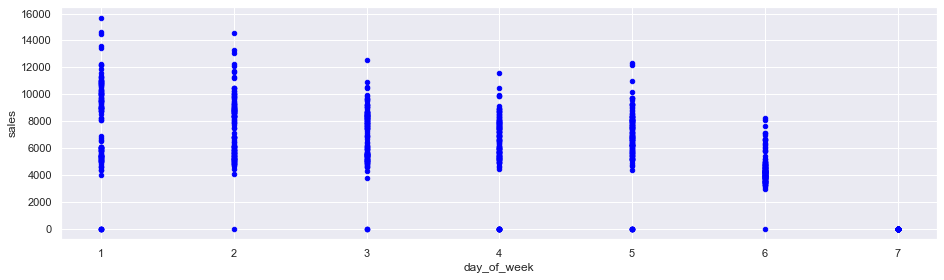

In [41]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store3[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

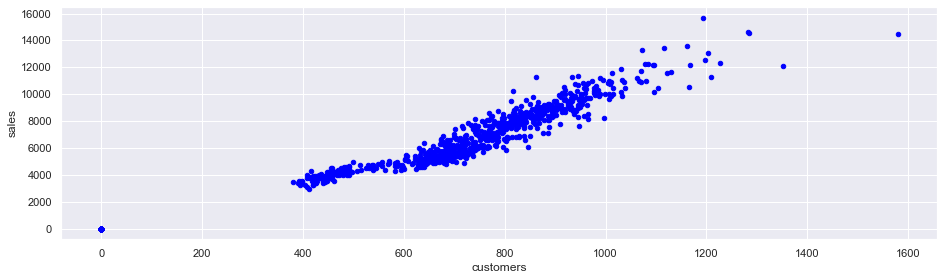

In [42]:
#Let's draw a scatter plot between Sales and Customers
df_store3[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

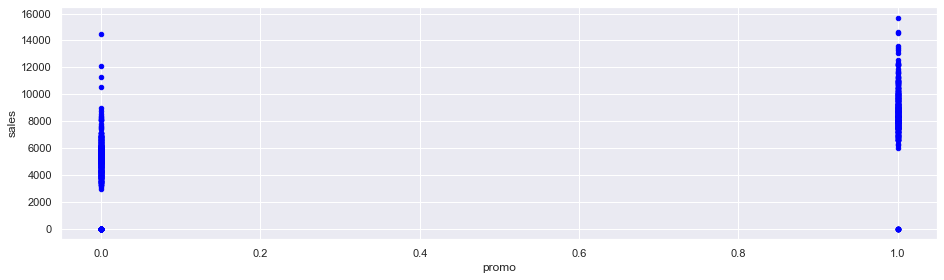

In [43]:
#Let's now draw a scatter plot between Sales and promo
df_store3[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

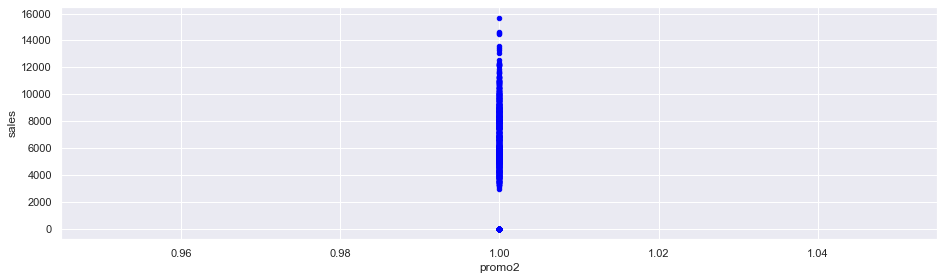

In [44]:
#Let's now draw a scatter plot between Sales and promo
df_store3[['sales', 'promo2']].plot.scatter(x = 'promo2',y='sales',c='blue')
plt.show()

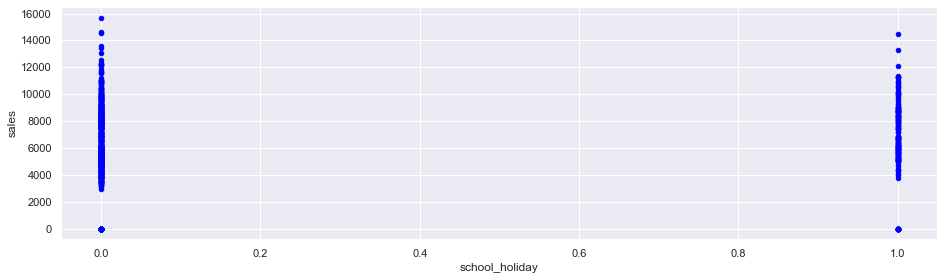

In [45]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store3[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

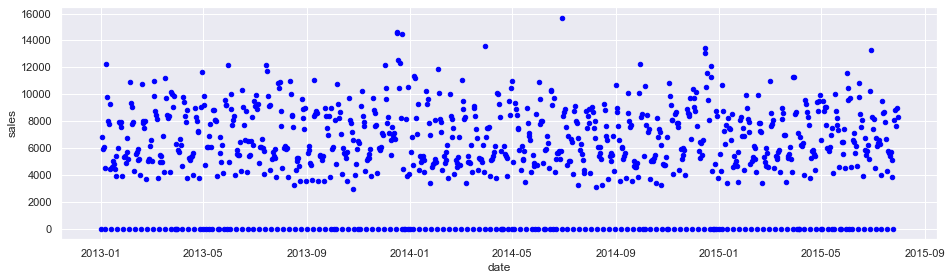

In [46]:
#lets now draw a scatter plot between Sales and date
df_store3[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

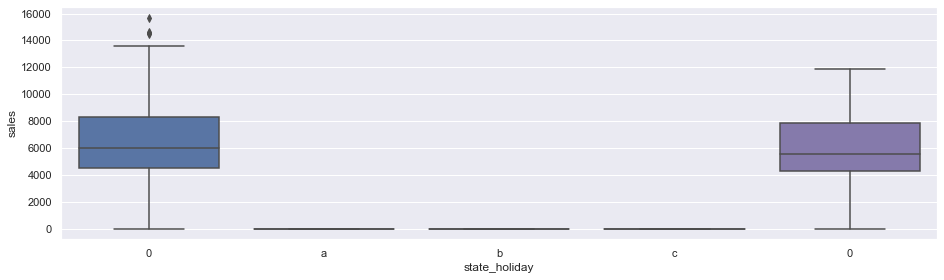

In [47]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store3['state_holiday'],
            y = df_store3['sales'])
plt.show()

**Multivariate Analysis**


**Numerical Attributes**


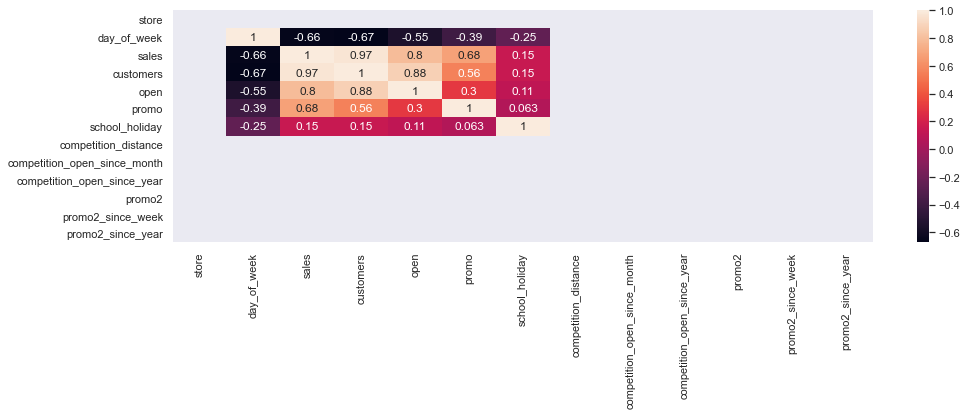

In [48]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

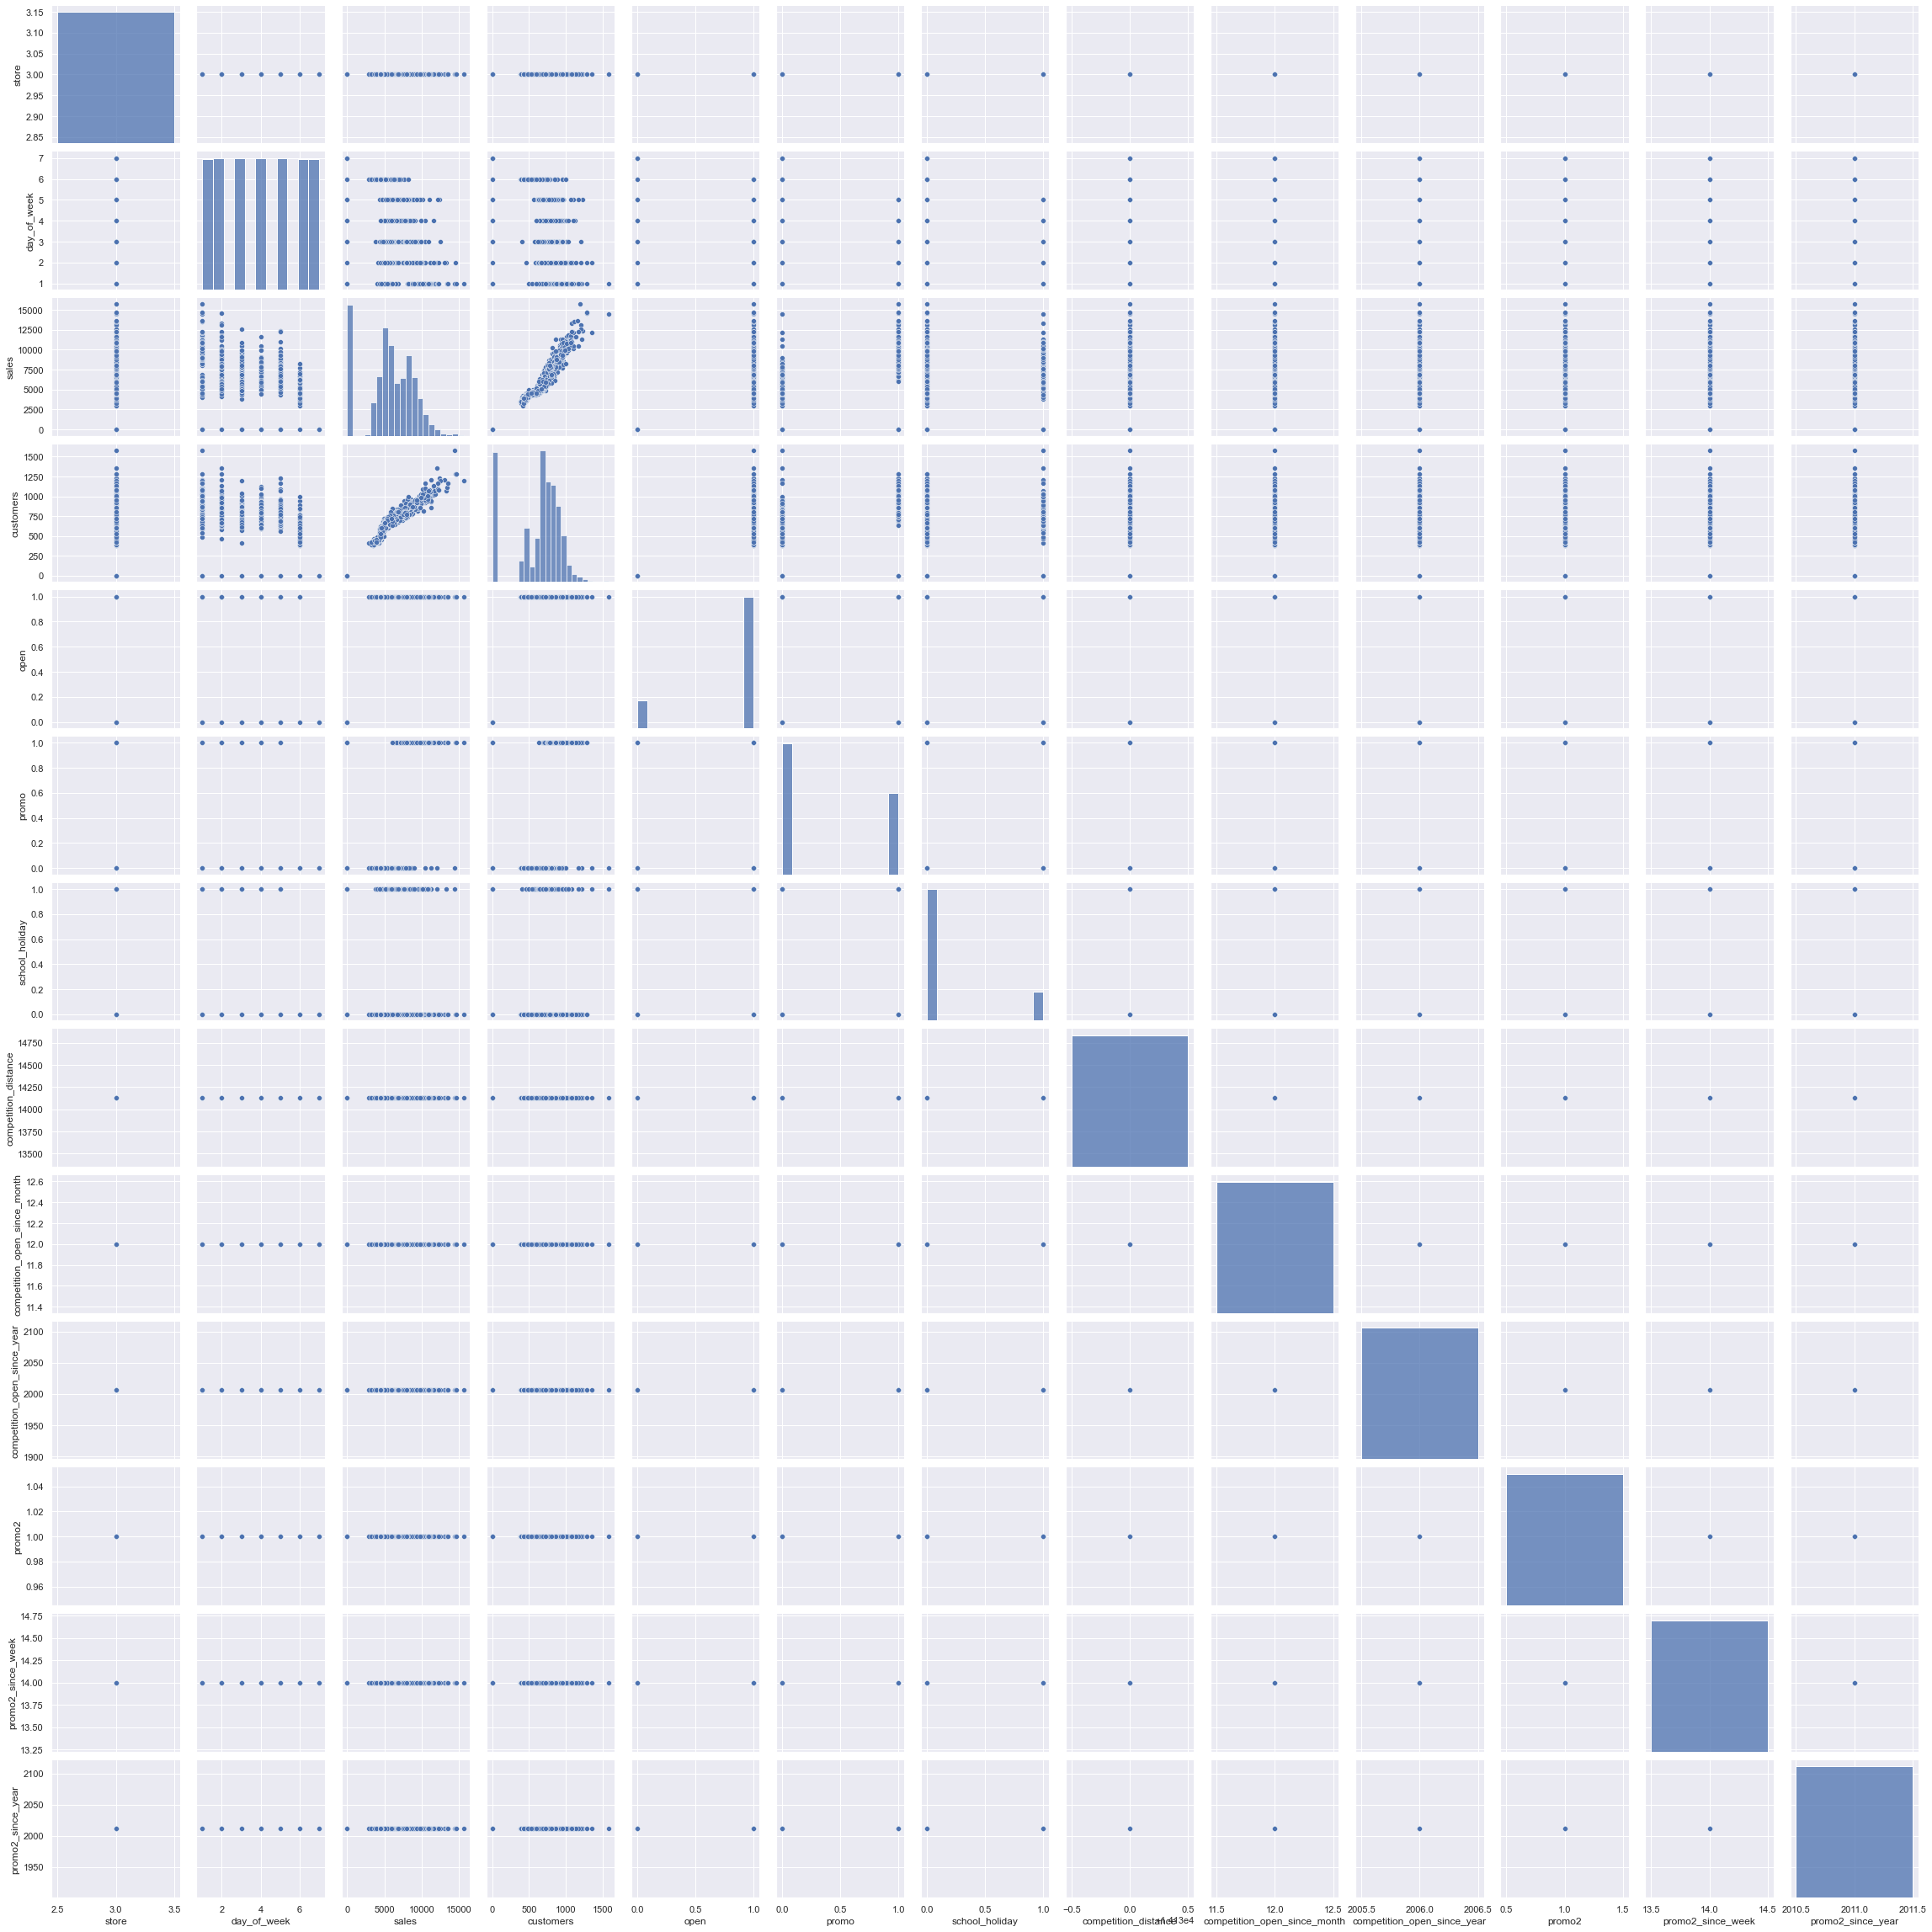

In [49]:
# pairplot with hue sales
sns.pairplot(df_store3)
# to show
plt.show()

**Some insights from EDA**


-   Sales & Customers are directly proportional to each other

-   store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,Promo2SinceWeek,Promo2SinceYear,PromoInterval

    
-    Day1,Day2 and Day5 have higher sales than other days
    
-    promo is correlated to sales

-    Promo2 doesn't have any effect on sales becuase it's value is equal to 1
    
-    There is no sale on a = public holiday, b = Easter holiday, c = Christmas
    
-    There is some effect of school holiday on sales


In [50]:
# We can drop store_type,assortment,competition_distance,competition_open_since_month,promo2_since_week,promo2_since_year,promo_interval
#competition_open_since_year & promo2
df_store3_new=df_store3.drop(['store_type', 'assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year','promo_interval'], axis = 1)

In [51]:
df_store3_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 2 to 1016097
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 121.0+ KB


In [52]:
df_store3_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
2,3,5,2015-07-31,8314,821,1,1,0,1,1
1117,3,4,2015-07-30,8977,823,1,1,0,1,1
2232,3,3,2015-07-29,7610,716,1,1,0,1,1
3347,3,2,2015-07-28,8864,818,1,1,0,1,1
4462,3,1,2015-07-27,8107,768,1,1,0,1,1


In [53]:
# saving the dataframe
#df_store3_new.to_csv('cleaned_df_store3.csv')

# Model Building

**ARIMA model**

In [54]:
path = "cleaned_df_store3.csv"
df_store3_new = pd.read_csv(path)
df_store3_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,2,3,5,2015-07-31,8314,821,1,1,0,1,1
1,1117,3,4,2015-07-30,8977,823,1,1,0,1,1
2,2232,3,3,2015-07-29,7610,716,1,1,0,1,1
3,3347,3,2,2015-07-28,8864,818,1,1,0,1,1
4,4462,3,1,2015-07-27,8107,768,1,1,0,1,1


In [55]:
df_store3_new=df_store3_new[::-1].reset_index()
df_store3_new

,index,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,1016097,3,2,2013-01-01,0,0,0,0,a,1,1
1,1014982,3,3,2013-01-02,6823,805,1,0,0,1,1
2,1013867,3,4,2013-01-03,5902,721,1,0,0,1,1
3,1012752,3,5,2013-01-04,6069,690,1,0,0,1,1
4,1011637,3,6,2013-01-05,4523,525,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
937,4462,3,1,2015-07-27,8107,768,1,1,0,1,1
938,3347,3,2,2015-07-28,8864,818,1,1,0,1,1
939,2232,3,3,2015-07-29,7610,716,1,1,0,1,1
940,1117,3,4,2015-07-30,8977,823,1,1,0,1,1


In [56]:
df_store3_new=df_store3_new.drop(['index'], axis = 1)
df_store3_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,3,2,2013-01-01,0,0,0,0,a,1,1
1,3,3,2013-01-02,6823,805,1,0,0,1,1
2,3,4,2013-01-03,5902,721,1,0,0,1,1
3,3,5,2013-01-04,6069,690,1,0,0,1,1
4,3,6,2013-01-05,4523,525,1,0,0,0,1


In [57]:
df_store3_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 73.7+ KB


In [58]:
indexed_df_store3_new = df_store3_new.set_index(['date'])
indexed_df_store3_new.head(5)
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,3,2,0,0,0,0,a,1,1
2013-01-02,3,3,6823,805,1,0,0,1,1
2013-01-03,3,4,5902,721,1,0,0,1,1
2013-01-04,3,5,6069,690,1,0,0,1,1
2013-01-05,3,6,4523,525,1,0,0,0,1


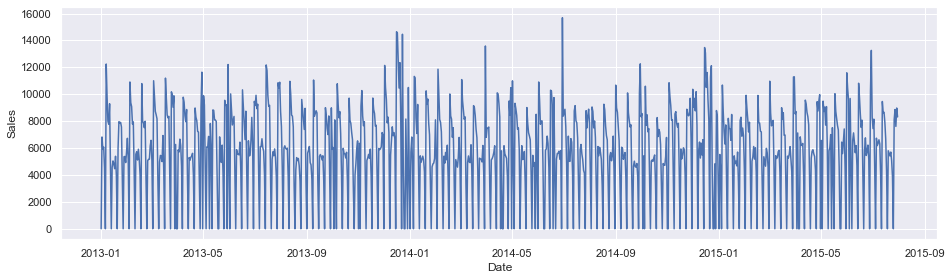

In [59]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store3_new['sales'])
plt.show()

In [60]:
#Let impute the zero values
(indexed_df_store3_new['sales']==0).sum()
# There are 163 zero value in sale column

163

In [61]:
indexed_df_store3_new['sales']=indexed_df_store3_new['sales'].replace(0, np.nan)

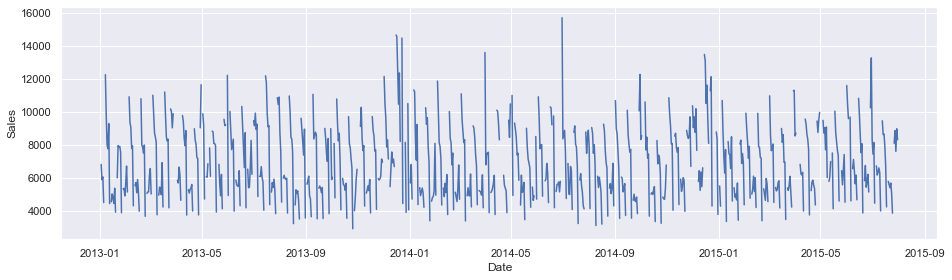

In [62]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store3_new['sales'])
plt.show()

In [63]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [64]:
indexed_df_store3_new['sales'] = imputer.fit_transform(np.array(indexed_df_store3_new['sales']).reshape(-1, 1))
indexed_df_store3_new['sales']

date
2013-01-01    6942.568678
2013-01-02    6823.000000
2013-01-03    5902.000000
2013-01-04    6069.000000
2013-01-05    4523.000000
                 ...     
2015-07-27    8107.000000
2015-07-28    8864.000000
2015-07-29    7610.000000
2015-07-30    8977.000000
2015-07-31    8314.000000
Name: sales, Length: 942, dtype: float64

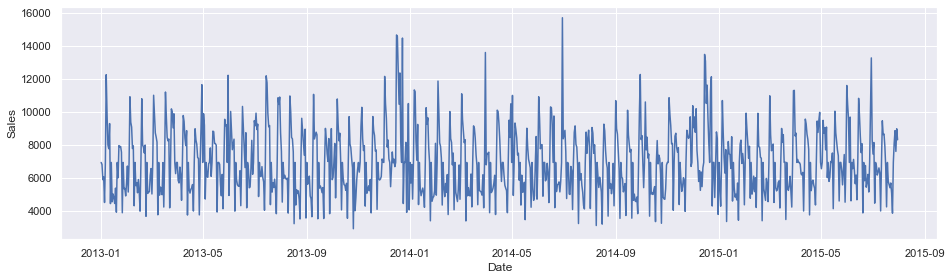

In [65]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store3_new['sales'])
plt.show()

In [66]:
(indexed_df_store3_new['sales']==0).sum()
# no missing value

0

**Outlier detection**

Box plot and interquartile range

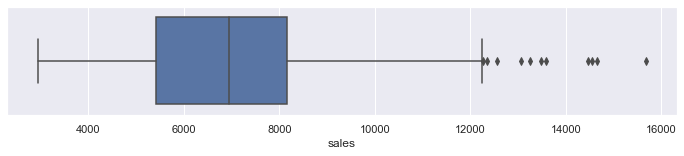

In [67]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store3_new['sales'],whis=1.5)
#Let treat the outliers

**Histogram**


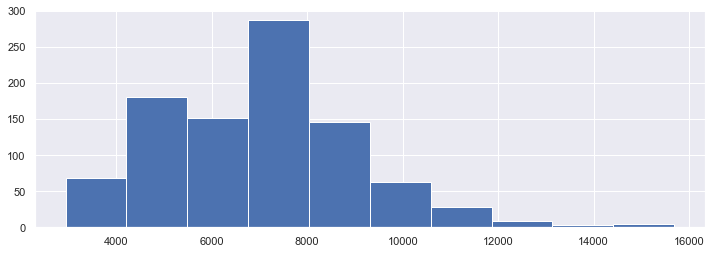

In [68]:
fig = indexed_df_store3_new['sales'].hist(figsize = (12,4))

In [69]:
percentile01 = indexed_df_store3_new['sales'].quantile(0.01)
percentile99 = indexed_df_store3_new['sales'].quantile(0.99)

In [70]:
upper_limit = percentile99
lower_limit = percentile01

In [71]:
upper_limit

12314.280000000002

In [72]:
lower_limit

3417.23

In [73]:
new_df = indexed_df_store3_new[indexed_df_store3_new['sales'] < upper_limit]
new_df.shape

(932, 9)

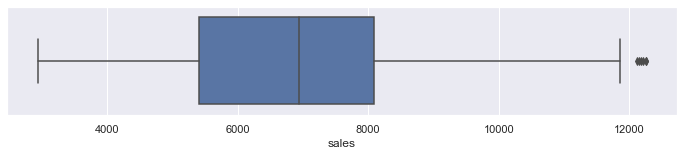

In [74]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['sales'],whis=1.5)

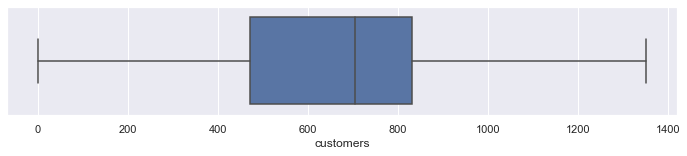

In [75]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['customers'],whis=1.5)

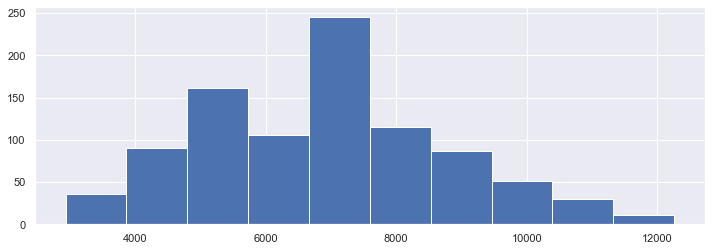

In [76]:
fig = new_df['sales'].hist(figsize = (12,4))

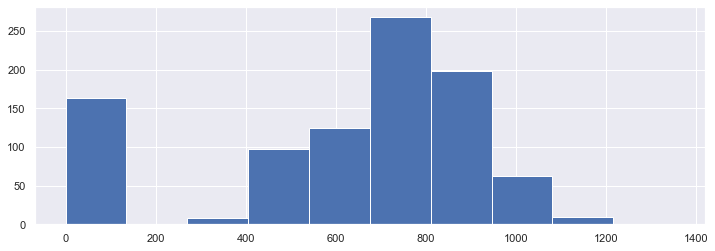

In [77]:
fig = new_df['customers'].hist(figsize = (12,4))

**ADF Stationary test**

In [78]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store3_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

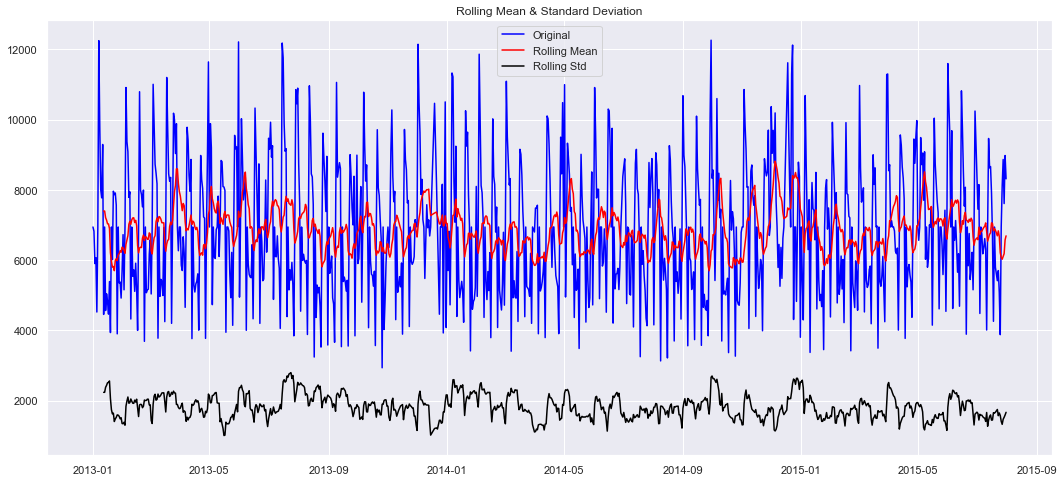

Results of Dickey Fuller Test:
Test Statistic                  -5.406938
p-value                          0.000003
#Lags Used                      21.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64


In [163]:
test_stationarity(new_df['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [80]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.080625
Critical Values @ 0.05: 0.46
p-value: 0.100000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary
    
**The p-value is greater than 0.05 so The series is stationary**

# Let's take the log of sales to Standardize the sales values

In [81]:
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,3,2,6942.568678,0,0,0,a,1,1
2013-01-02,3,3,6823.000000,805,1,0,0,1,1
2013-01-03,3,4,5902.000000,721,1,0,0,1,1
2013-01-04,3,5,6069.000000,690,1,0,0,1,1
2013-01-05,3,6,4523.000000,525,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
2015-07-27,3,1,8107.000000,768,1,1,0,1,1
2015-07-28,3,2,8864.000000,818,1,1,0,1,1
2015-07-29,3,3,7610.000000,716,1,1,0,1,1


In [82]:
#Log Transformation
new_df['sales_log'] = np.log(new_df['sales'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log
date,,,,,,,,,,
2013-01-01,3,2,6942.568678,0,0,0,a,1,1,8.845427
2013-01-02,3,3,6823.000000,805,1,0,0,1,1,8.828055
2013-01-03,3,4,5902.000000,721,1,0,0,1,1,8.683047
2013-01-04,3,5,6069.000000,690,1,0,0,1,1,8.710949
2013-01-05,3,6,4523.000000,525,1,0,0,0,1,8.416931
...,...,...,...,...,...,...,...,...,...,...
2015-07-27,3,1,8107.000000,768,1,1,0,1,1,9.000483
2015-07-28,3,2,8864.000000,818,1,1,0,1,1,9.089753
2015-07-29,3,3,7610.000000,716,1,1,0,1,1,8.937218


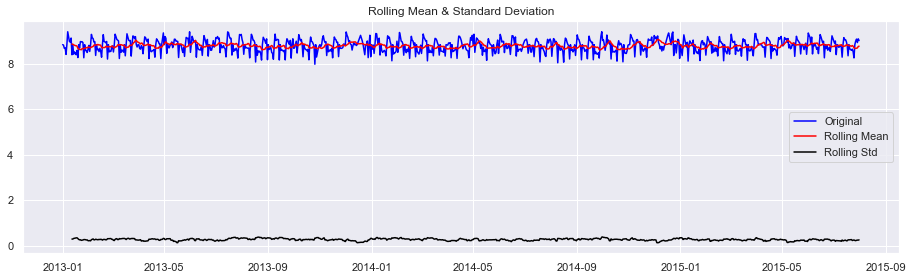

Results of Dickey Fuller Test:
Test Statistic                -5.935634e+00
p-value                        2.324597e-07
#Lags Used                     2.200000e+01
Number of Observations Used    9.190000e+02
Critical Value (1%)           -3.437486e+00
Critical Value (5%)           -2.864690e+00
Critical Value (10%)          -2.568447e+00
dtype: float64


In [83]:
test_stationarity(new_df['sales_log'])

In [84]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales_log'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.090802
Critical Values @ 0.05: 0.46
p-value: 0.100000


**Log transformation has made mean & variance constant**

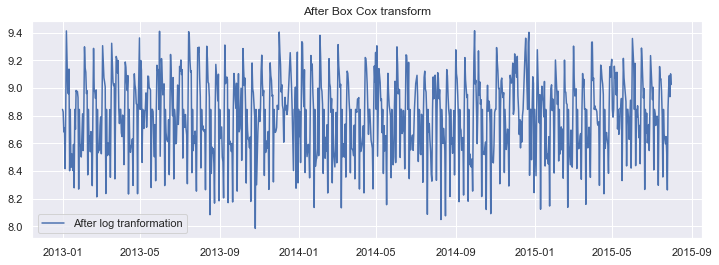

In [85]:
#After Log Transformation
plt.figure(figsize=(12,4))
plt.plot(new_df['sales_log'], label='After log tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

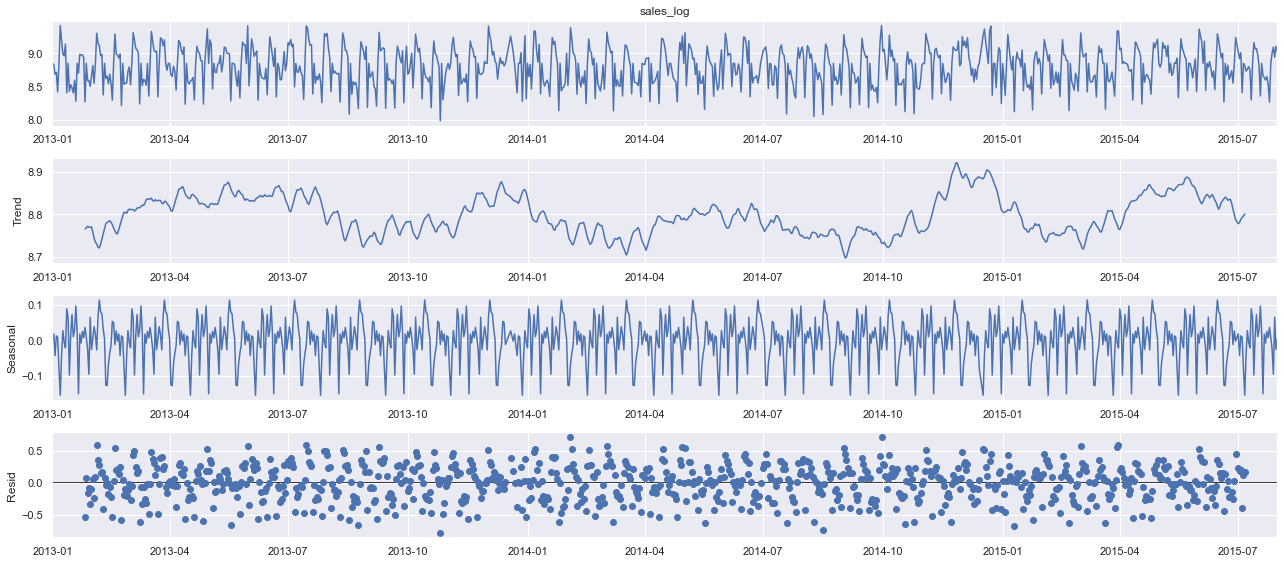

In [86]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "additive",period=50)
fig = decomposition.plot()

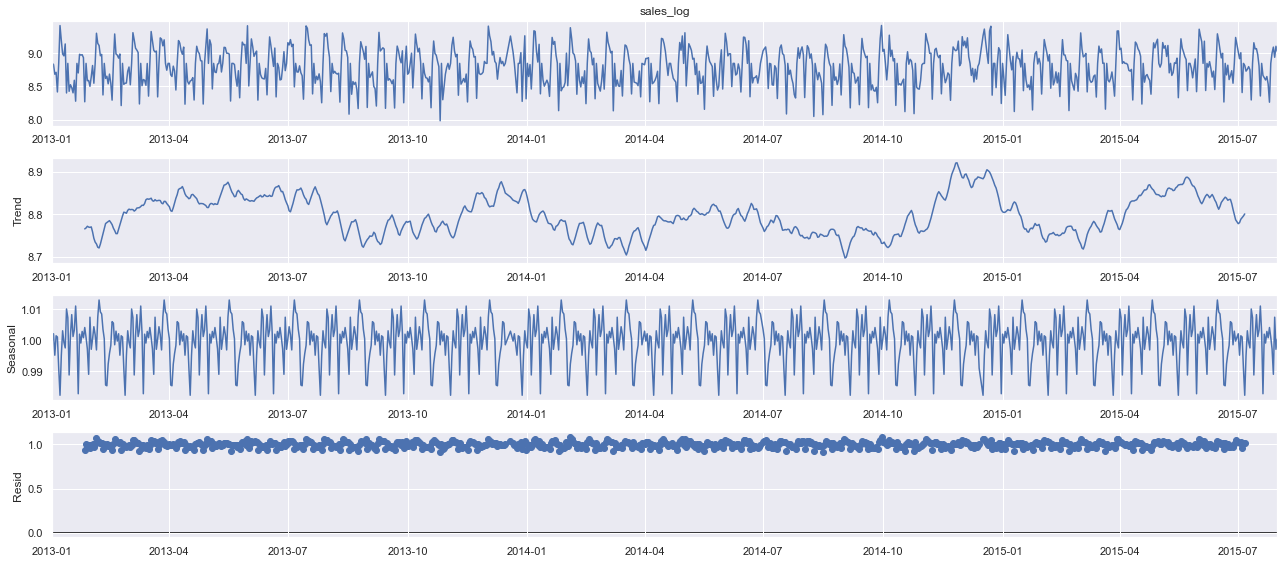

In [87]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "multiplicative",period=50)
fig = decomposition.plot()

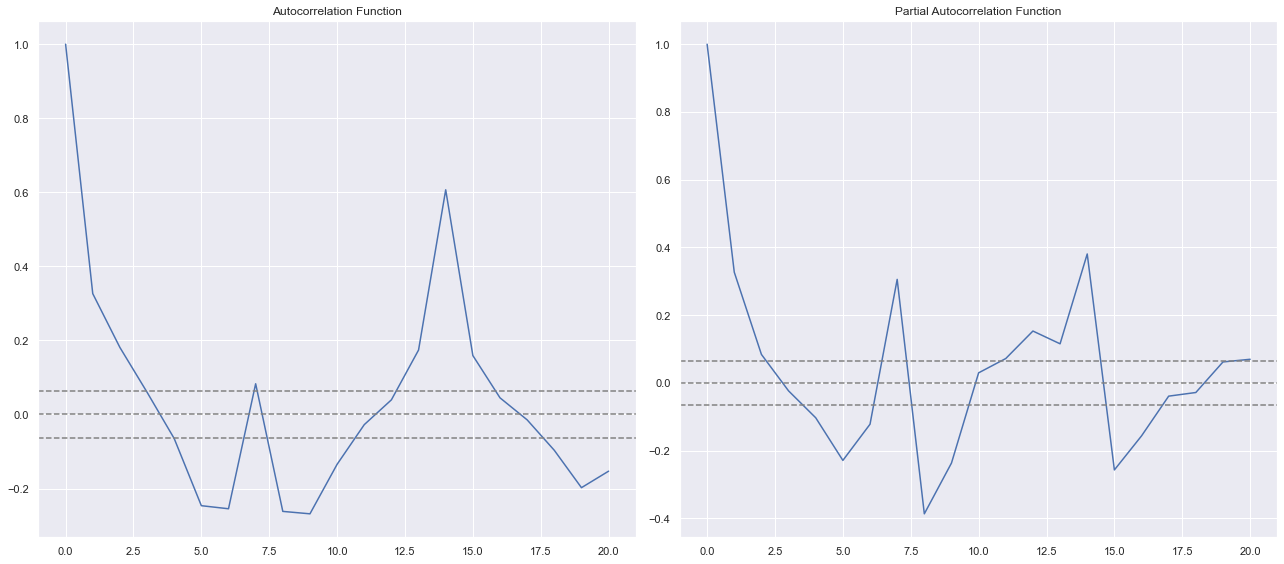

In [88]:
#ACF & PACF plots

lag_acf = acf(new_df['sales_log'], nlags=20) # MA 
lag_pacf = pacf(new_df['sales_log'], nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=4. Thus, from theory, Q = 4 From the PACF graph, we see that curve touches y=0.0 line at x=3. Thus, from theory, P = 3

**Build and evaluate time series forecast**

Split time series data into training and test set


In [89]:
train_len = 750
train = new_df['sales'][0:train_len] # first 750days as training set
test = new_df['sales'][train_len:] # last 182 days as out-of-time test set

In [90]:
print(train.shape)
print(test.shape)

(750,)
(182,)


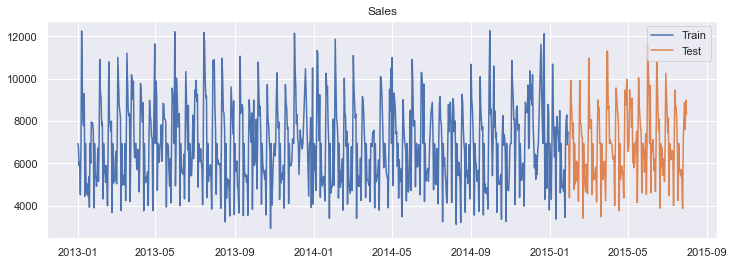

In [91]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [92]:
model = ARIMA(new_df['sales_log'], order=(3, 0, 4))
model_fit = model.fit()
print(model_fit.params)

const              8.796791
ar.L1.sales_log    0.349763
ar.L2.sales_log    0.015565
ar.L3.sales_log   -0.670448
ma.L1.sales_log   -0.107128
ma.L2.sales_log    0.101547
ma.L3.sales_log    0.786016
ma.L4.sales_log    0.041574
dtype: float64


In [93]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    6612.987317
2013-01-02    6717.449950
2013-01-03    6692.139306
2013-01-04    6378.091686
2013-01-05    6328.607872
                 ...     
2015-07-27    6916.820318
2015-07-28    8011.036766
2015-07-29    8366.109651
2015-07-30    7101.661732
2015-07-31    6379.617670
Name: arima_forecast, Length: 932, dtype: float64

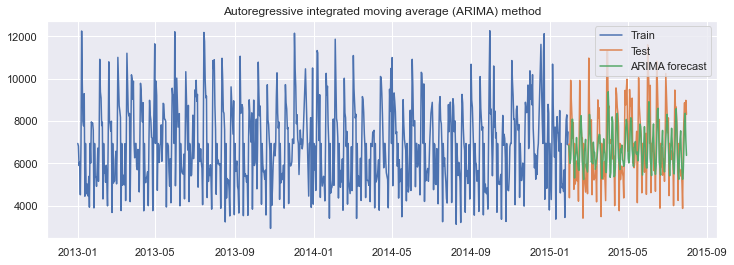

In [94]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

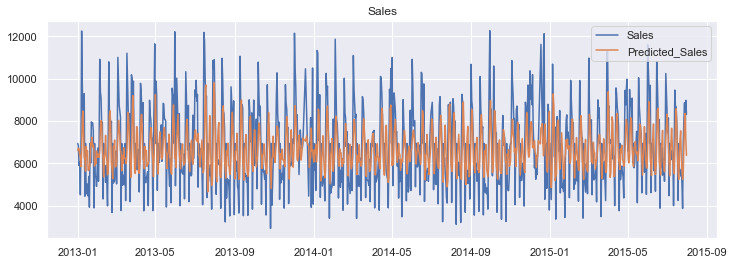

In [95]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Sales')
plt.plot(new_df['arima_forecast'], label='Predicted_Sales')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results 

,Method,RMSE,MAPE
0,ARIMA,1519.86,18.4


**VAR model**

In [97]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,3,2,6942.568678,0,0,0,a,1,1,8.845427,8.796791,6612.987317
2013-01-02,3,3,6823.000000,805,1,0,0,1,1,8.828055,8.812464,6717.449950
2013-01-03,3,4,5902.000000,721,1,0,0,1,1,8.683047,8.808689,6692.139306
2013-01-04,3,5,6069.000000,690,1,0,0,1,1,8.710949,8.760624,6378.091686
2013-01-05,3,6,4523.000000,525,1,0,0,0,1,8.416931,8.752836,6328.607872


**Split the dataset to training & testing**


In [98]:
#split the dataset
nobs = 182
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(750, 12)
(182, 12)


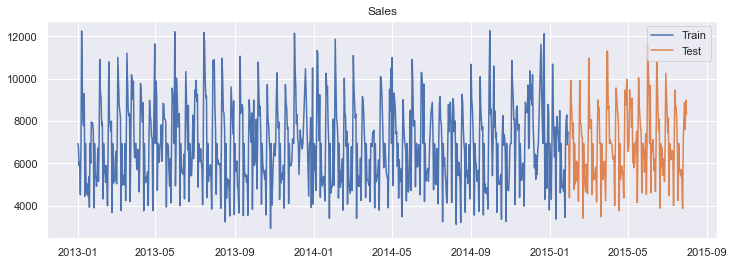

In [99]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

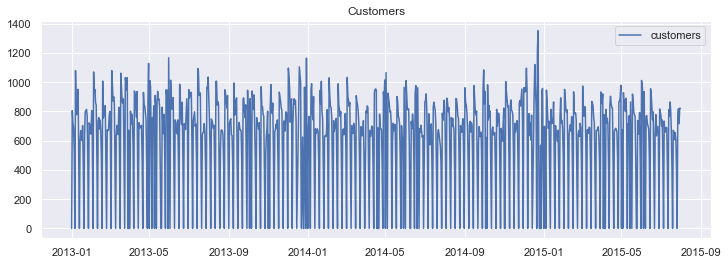

In [100]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [101]:
(new_df['customers']==0).sum()

163

In [102]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

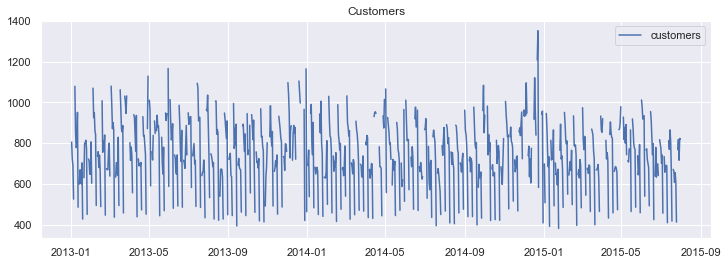

In [103]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [104]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [105]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers']

date
2013-01-01    743.816645
2013-01-02    805.000000
2013-01-03    721.000000
2013-01-04    690.000000
2013-01-05    525.000000
                 ...    
2015-07-27    768.000000
2015-07-28    818.000000
2015-07-29    716.000000
2015-07-30    823.000000
2015-07-31    821.000000
Name: customers, Length: 932, dtype: float64

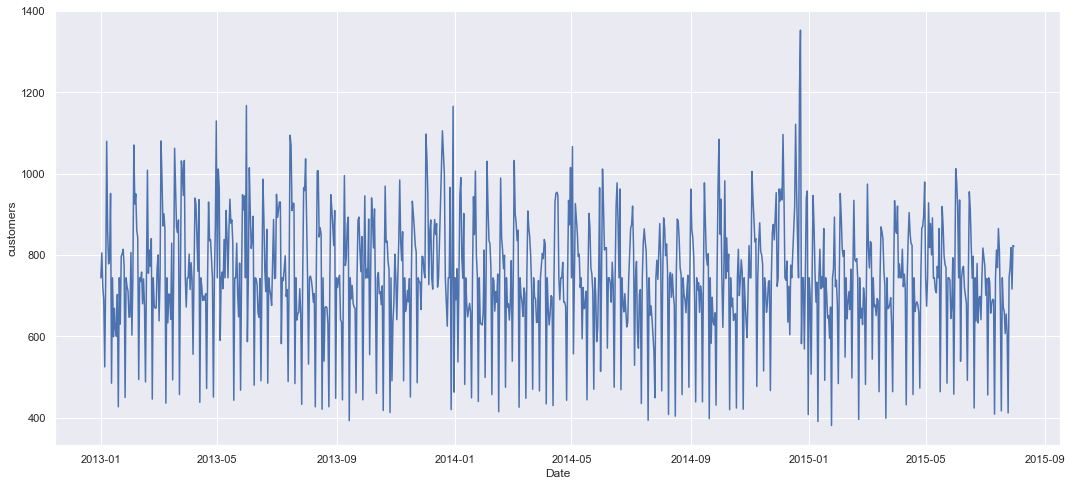

In [106]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [107]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,3,2,6942.568678,743.816645,0,0,a,1,1,8.845427,8.796791,6612.987317
2013-01-02,3,3,6823.000000,805.000000,1,0,0,1,1,8.828055,8.812464,6717.449950
2013-01-03,3,4,5902.000000,721.000000,1,0,0,1,1,8.683047,8.808689,6692.139306
2013-01-04,3,5,6069.000000,690.000000,1,0,0,1,1,8.710949,8.760624,6378.091686
2013-01-05,3,6,4523.000000,525.000000,1,0,0,0,1,8.416931,8.752836,6328.607872


**ADF Test**

In [108]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(new_df['customers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

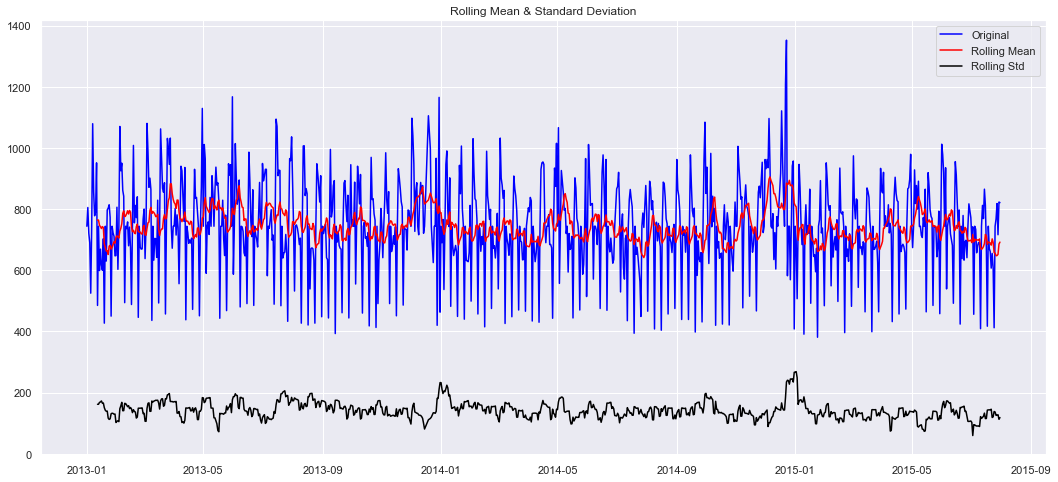

Results of Dickey Fuller Test:
Test Statistic                  -5.406938
p-value                          0.000003
#Lags Used                      21.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64


In [109]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [110]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['customers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.344871
Critical Values @ 0.05: 0.46
p-value: 0.100000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is greater than 0.05 so The series is stationary**

In [111]:
#Log Transformation
new_df['customers_log'] = np.log(new_df['customers'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,3,2,6942.568678,743.816645,0,0,a,1,1,8.845427,8.796791,6612.987317,6.611795
2013-01-02,3,3,6823.000000,805.000000,1,0,0,1,1,8.828055,8.812464,6717.449950,6.690842
2013-01-03,3,4,5902.000000,721.000000,1,0,0,1,1,8.683047,8.808689,6692.139306,6.580639
2013-01-04,3,5,6069.000000,690.000000,1,0,0,1,1,8.710949,8.760624,6378.091686,6.536692
2013-01-05,3,6,4523.000000,525.000000,1,0,0,0,1,8.416931,8.752836,6328.607872,6.263398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,3,1,8107.000000,768.000000,1,1,0,1,1,9.000483,8.841711,6916.820318,6.643790
2015-07-28,3,2,8864.000000,818.000000,1,1,0,1,1,9.089753,8.988575,8011.036766,6.706862
2015-07-29,3,3,7610.000000,716.000000,1,1,0,1,1,8.937218,9.031944,8366.109651,6.573680


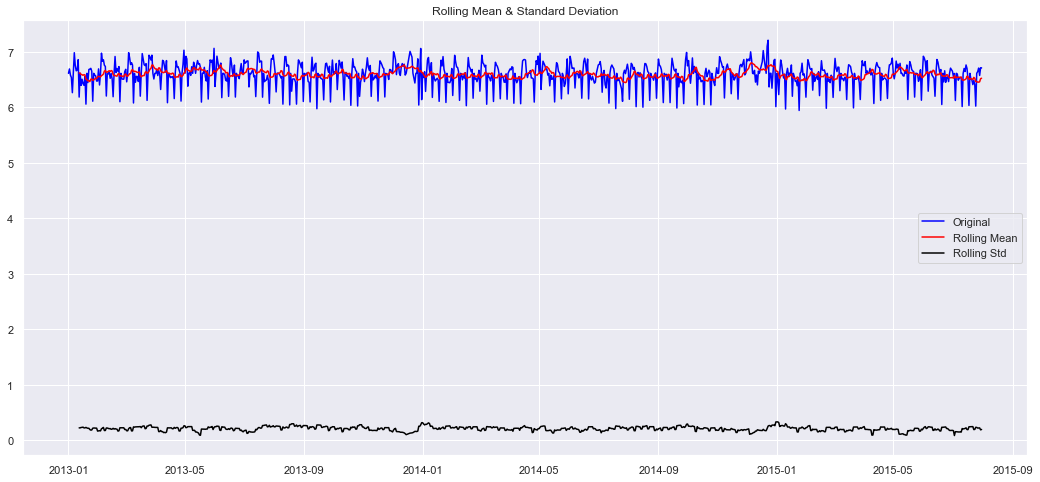

Results of Dickey Fuller Test:
Test Statistic                  -5.406938
p-value                          0.000003
#Lags Used                      21.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64


In [112]:
test_stationarity(new_df['customers_log'])

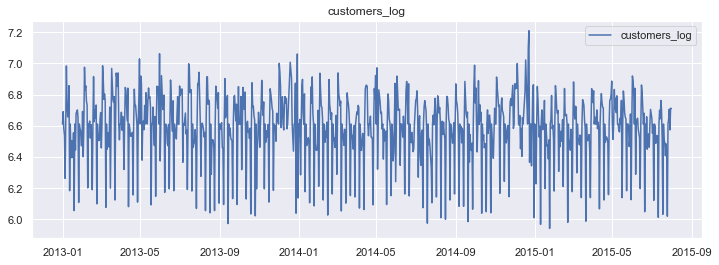

In [113]:
#plot the arima Log series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers_log'],label='customers_log')
plt.legend(loc='best')
plt.title('customers_log')
plt.show()

In [114]:
#Let's check the info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2013-01-01 to 2015-07-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            932 non-null    int64  
 1   day_of_week      932 non-null    int64  
 2   sales            932 non-null    float64
 3   customers        932 non-null    float64
 4   open             932 non-null    int64  
 5   promo            932 non-null    int64  
 6   state_holiday    932 non-null    object 
 7   school_holiday   932 non-null    int64  
 8   promo2           932 non-null    int64  
 9   sales_log        932 non-null    float64
 10  ar_forecast_Log  932 non-null    float64
 11  arima_forecast   932 non-null    float64
 12  customers_log    932 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 141.9+ KB


**Log transformation has made mean & variance constant**

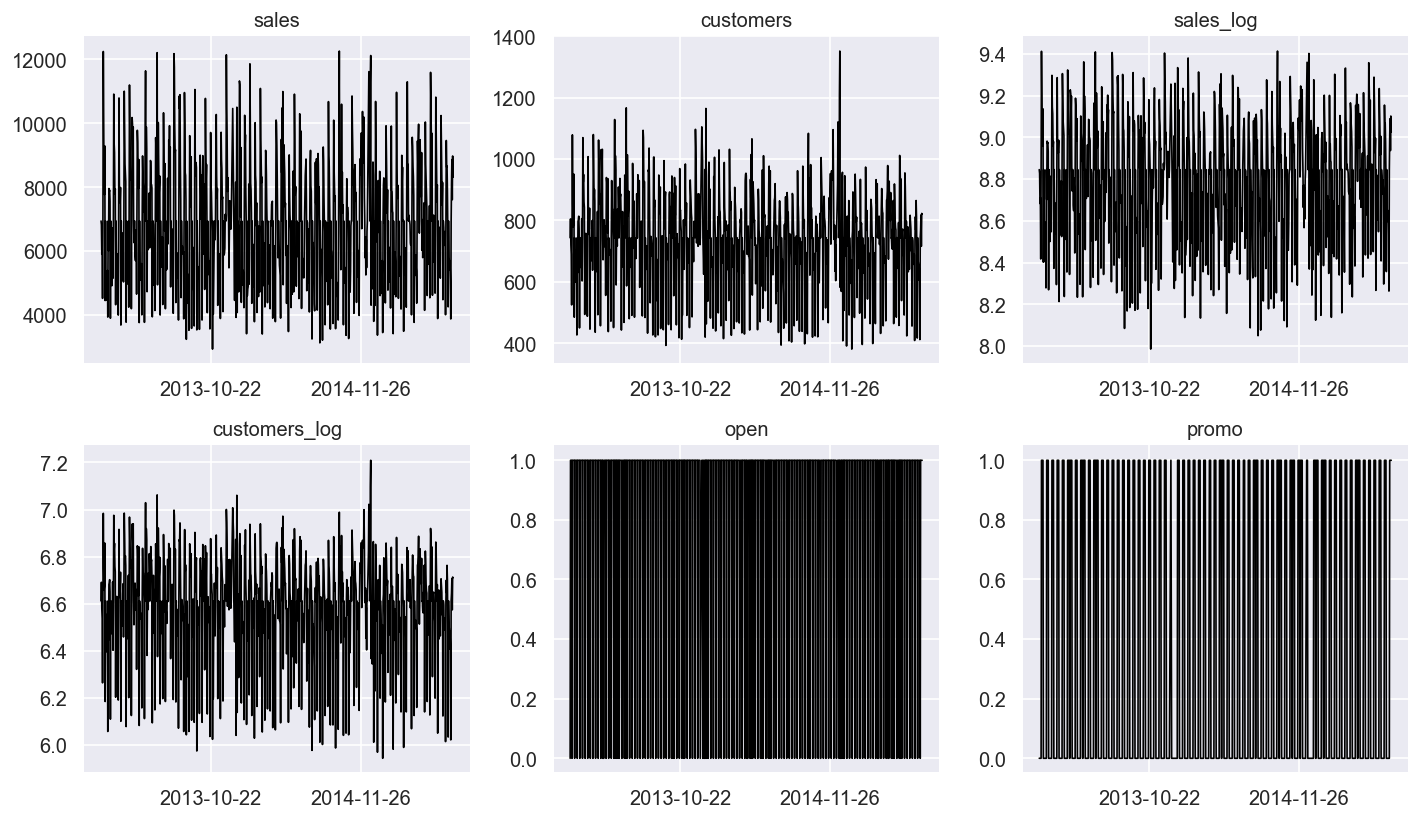

In [115]:
# Plot
ls=['sales','customers','sales_log','customers_log','open','promo','state_holiday','promo2','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [116]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2', 'sales_log',
       'ar_forecast_Log', 'arima_forecast', 'customers_log'],
      dtype='object')

In [117]:
new_df1=new_df[['sales_log', 'customers_log']]
new_df1

,sales_log,customers_log
date,,
2013-01-01,8.845427,6.611795
2013-01-02,8.828055,6.690842
2013-01-03,8.683047,6.580639
2013-01-04,8.710949,6.536692
2013-01-05,8.416931,6.263398
...,...,...
2015-07-27,9.000483,6.643790
2015-07-28,9.089753,6.706862
2015-07-29,8.937218,6.573680


In [118]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.32516970434931
BIC :  -8.294001545741724
FPE :  0.00024233980598850106
HQIC:  -8.313282606268764 

Lag Order = 2
AIC :  -8.343798026043075
BIC :  -8.291806793933963
FPE :  0.00023786724861577763
HQIC:  -8.323968273874659 

Lag Order = 3
AIC :  -8.372356702944204
BIC :  -8.299506840357127
FPE :  0.0002311702438507642
HQIC:  -8.344569910887888 

Lag Order = 4
AIC :  -8.438561372896219
BIC :  -8.344817222906832
FPE :  0.00021636145272857174
HQIC:  -8.402803113678413 

Lag Order = 5
AIC :  -8.531438065755092
BIC :  -8.416763871103043
FPE :  0.00019717166006528582
HQIC:  -8.487693870465367 



In [119]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,-7.826,-7.816,0.0003992,-7.822
1,-8.322,-8.291,0.0002432,-8.310
2,-8.340,-8.288,0.0002387,-8.321
3,-8.371,-8.298,0.0002315,-8.343
4,-8.439,-8.345,0.0002164,-8.403
5,-8.531*,-8.417*,0.0001972*,-8.488*


In [120]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jan, 2022
Time:                     16:24:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.29400
Nobs:                     931.000    HQIC:                  -8.31328
Log likelihood:           1239.30    FPE:                0.000242340
AIC:                     -8.32517    Det(Omega_mle):     0.000240786
--------------------------------------------------------------------
Results for equation sales_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    6.347709         0.253876           25.003           0.000
L1.sales_log             1.366464         0.085893           15.909           0.000
L1.customers_log        -1.452291         0.

In [121]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [122]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[9.02569612, 6.71052311]])

In [123]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=182)
df_forecast = pd.DataFrame(fc, index=new_df.index[-182:], columns=new_df1.columns + '_2d')
df_forecast

,sales_log_2d,customers_log_2d
date,,
2015-01-30,8.935365,6.663511
2015-01-31,8.880206,6.634493
2015-02-01,8.846976,6.616989
2015-02-02,8.826988,6.606459
2015-02-03,8.814969,6.600127
...,...,...
2015-07-27,8.796838,6.590575
2015-07-28,8.796838,6.590575
2015-07-29,8.796838,6.590575


In [124]:
df_forecast['VAR_forecast_Sales'] = np.exp(df_forecast['sales_log_2d'])
df_forecast['VAR_forecast_customers'] = np.exp(df_forecast['customers_log_2d'])
df_forecast

,sales_log_2d,customers_log_2d,VAR_forecast_Sales,VAR_forecast_customers
date,,,,
2015-01-30,8.935365,6.663511,7595.906086,783.295913
2015-01-31,8.880206,6.634493,7188.271521,760.893231
2015-02-01,8.846976,6.616989,6953.326963,747.690431
2015-02-02,8.826988,6.606459,6815.728112,739.858649
2015-02-03,8.814969,6.600127,6734.296562,735.188415
...,...,...,...,...
2015-07-27,8.796838,6.590575,6613.300845,728.199458
2015-07-28,8.796838,6.590575,6613.300845,728.199458
2015-07-29,8.796838,6.590575,6613.300845,728.199458


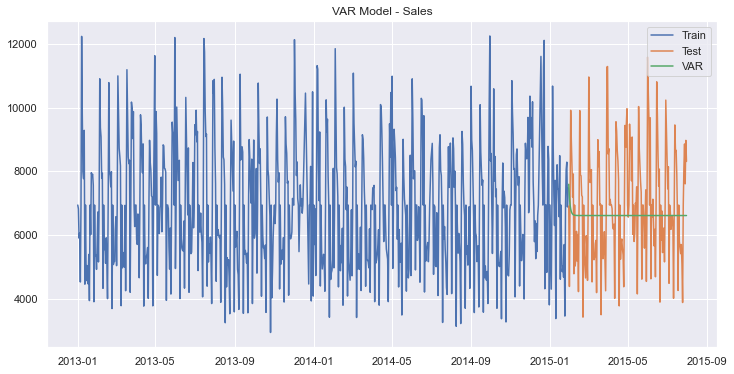

In [125]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['VAR_forecast_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [131]:
train_len = 750
train1 = new_df[0:train_len] # first 890days as training set
test1 = new_df[train_len:] # last 42 days as out-of-time test set

In [132]:
train1

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,3,2,6942.568678,743.816645,0,0,a,1,1,8.845427,8.796791,6612.987317,6.611795
2013-01-02,3,3,6823.000000,805.000000,1,0,0,1,1,8.828055,8.812464,6717.449950,6.690842
2013-01-03,3,4,5902.000000,721.000000,1,0,0,1,1,8.683047,8.808689,6692.139306,6.580639
2013-01-04,3,5,6069.000000,690.000000,1,0,0,1,1,8.710949,8.760624,6378.091686,6.536692
2013-01-05,3,6,4523.000000,525.000000,1,0,0,0,1,8.416931,8.752836,6328.607872,6.263398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-25,3,7,6942.568678,743.816645,0,0,0,0,1,8.845427,8.767606,6422.775277,6.611795
2015-01-26,3,1,8055.000000,765.000000,1,1,0,0,1,8.994048,8.869292,7110.245653,6.639876
2015-01-27,3,2,8292.000000,893.000000,1,1,0,0,1,9.023046,8.829087,6830.046331,6.794587


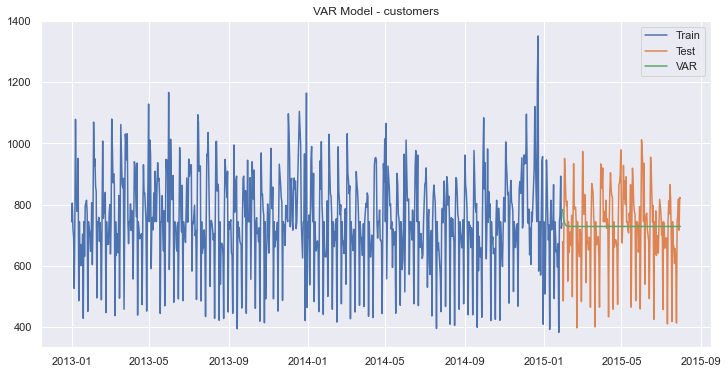

In [133]:
plt.figure(figsize=(12,6)) 
plt.plot(train1['customers'], label='Train')
plt.plot(test1['customers'], label='Test')
plt.plot(df_forecast['VAR_forecast_customers'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

In [134]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], df_forecast['VAR_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-df_forecast['VAR_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [135]:
tempResults

,Method,RMSE,MAPE
0,VAR,1756.6,21.02


In [136]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1519.86,18.40
0,VAR,1756.60,21.02


**Johansen-Impulse**


In [137]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [138]:
joh_model1

In [139]:
joh_model1.lr2

array([157.55130451,   5.01440149])

In [140]:
joh_model1.lr1

array([162.56570601,   5.01440149])

In [141]:
new_df[['sales','customers']].shape

(932, 2)

In [142]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [143]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    157.551305  162.565706
1      5.014401    5.014401 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [144]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [145]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

2


**Rank is one**


In [146]:
from statsmodels.tsa.stattools import coint

In [147]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-4.446660412686737,
 0.0014965352567214445,
 array([-3.90824227, -3.34270081, -3.04900867]))

0.0014965352567214445<.05

We can reject the null hypothesis

**Sales and customers are cointegration to each other**

**VARMAX MODEL**

In [148]:
#create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,,
2013-01-01,3,2,6942.568678,743.816645,0,0,1,1,8.845427,8.796791,6612.987317,6.611795,0,0,1,0,0
2013-01-02,3,3,6823.000000,805.000000,1,0,1,1,8.828055,8.812464,6717.449950,6.690842,0,1,0,0,0
2013-01-03,3,4,5902.000000,721.000000,1,0,1,1,8.683047,8.808689,6692.139306,6.580639,0,1,0,0,0
2013-01-04,3,5,6069.000000,690.000000,1,0,1,1,8.710949,8.760624,6378.091686,6.536692,0,1,0,0,0
2013-01-05,3,6,4523.000000,525.000000,1,0,0,1,8.416931,8.752836,6328.607872,6.263398,0,1,0,0,0


In [149]:
new_df

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,,
2013-01-01,3,2,6942.568678,743.816645,0,0,1,1,8.845427,8.796791,6612.987317,6.611795,0,0,1,0,0
2013-01-02,3,3,6823.000000,805.000000,1,0,1,1,8.828055,8.812464,6717.449950,6.690842,0,1,0,0,0
2013-01-03,3,4,5902.000000,721.000000,1,0,1,1,8.683047,8.808689,6692.139306,6.580639,0,1,0,0,0
2013-01-04,3,5,6069.000000,690.000000,1,0,1,1,8.710949,8.760624,6378.091686,6.536692,0,1,0,0,0
2013-01-05,3,6,4523.000000,525.000000,1,0,0,1,8.416931,8.752836,6328.607872,6.263398,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,3,1,8107.000000,768.000000,1,1,1,1,9.000483,8.841711,6916.820318,6.643790,0,1,0,0,0
2015-07-28,3,2,8864.000000,818.000000,1,1,1,1,9.089753,8.988575,8011.036766,6.706862,0,1,0,0,0
2015-07-29,3,3,7610.000000,716.000000,1,1,1,1,8.937218,9.031944,8366.109651,6.573680,0,1,0,0,0


In [151]:
exog = new_df[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales_log', 'customers_log']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['sales_log', 'customers_log']   No. Observations:                  932
Model:                                VARMAX(1,1)   Log Likelihood                1681.963
Date:                            Fri, 14 Jan 2022   AIC                          -3305.925
Time:                                    16:49:21   BIC                          -3165.643
Sample:                                         0   HQIC                         -3252.426
                                            - 932                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):             4.98, 0.19   Jarque-Bera (JB):         43.38, 26.47
Prob(Q):                        0.03, 0.66   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.10, 1.24   Skew:                     -0.01, -0.36
Prob(H) (two-sided):

In [152]:
train_len = 750
train = new_df[0:train_len] # first 7500days as training set
test = new_df[train_len:] 

start_index = test.index.min()
end_index = test.index.max()

In [153]:
print(start_index)
print(end_index)

2015-01-30 00:00:00
2015-07-31 00:00:00


In [154]:
test.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,,
2015-01-30,3,5,6911.000000,678.000000,1,1,0,1,8.840870,8.830685,6840.969472,6.519147,0,1,0,0,0
2015-01-31,3,6,4382.000000,484.000000,1,0,0,1,8.385261,8.776113,6477.646524,6.182085,0,1,0,0,0
2015-02-01,3,7,6942.568678,743.816645,0,0,0,1,8.845427,8.701087,6009.440053,6.611795,0,1,0,0,0
2015-02-02,3,1,9922.000000,951.000000,1,1,0,1,9.202510,8.735418,6219.331051,6.857514,0,1,0,0,0
2015-02-03,3,2,8950.000000,895.000000,1,1,0,1,9.099409,8.873189,7138.008890,6.796824,0,1,0,0,0


In [156]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']])

In [157]:
predictions

,sales_log,customers_log
date,,
2015-01-30,9.025164,6.720068
2015-01-31,8.629805,6.458239
2015-02-01,8.857687,6.611057
2015-02-02,8.991001,6.711418
2015-02-03,9.080953,6.762351
...,...,...
2015-07-27,9.056682,6.768625
2015-07-28,9.113662,6.786741
2015-07-29,9.138525,6.802992


In [158]:
predictions['VARMAX_forecast_Sales'] = np.exp(predictions['sales_log'])
predictions['VARMAX_forecast_customers'] = np.exp(predictions['customers_log'])
predictions

,sales_log,customers_log,VARMAX_forecast_Sales,VARMAX_forecast_customers
date,,,,
2015-01-30,9.025164,6.720068,8309.574734,828.874127
2015-01-31,8.629805,6.458239,5595.986573,637.936705
2015-02-01,8.857687,6.611057,7028.205178,743.267956
2015-02-02,8.991001,6.711418,8030.494297,821.734802
2015-02-03,9.080953,6.762351,8786.337110,864.672965
...,...,...,...,...
2015-07-27,9.056682,6.768625,8575.651827,870.114944
2015-07-28,9.113662,6.786741,9078.480806,886.021712
2015-07-29,9.138525,6.802992,9307.031455,900.537402


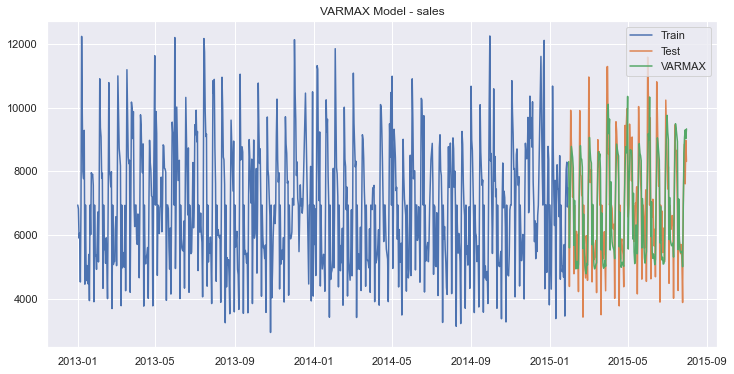

In [159]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['VARMAX_forecast_Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

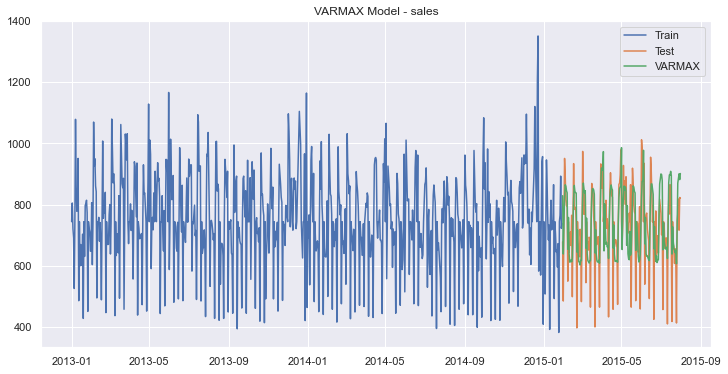

In [160]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['VARMAX_forecast_customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

# Model Evalution

In [161]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['VARMAX_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['VARMAX_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [162]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1519.86,18.40
0,VAR,1756.60,21.02
0,VARMAX,1100.05,12.62


**VARMAX is the best model**


-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   Standardize the sales and number of customers variables before modelling.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# Conclusion


-   The data is stationary
-   Sales and Customers are cointegrated to each others
-   Sales will get increase as the number of customer will get increase.
-   promo has positive impact on sales
-   promo2 doesn't have any impact on sales

